# Анализ рынка заведений общественного питания г. Москвы
### Цель  анализ текущего состояния рынка общественного питания г. Москвы 
### Задачи:
1. выполнить первичную обработку данных: убрать дубликаты, пропуски м др. ;<br>
2. дать общую характеристику объектам питания г Москва по типу заведений и количеству посадочных мест ;<br>
3. найти топ-10 улиц по количеству объектов питания и дать им характеристику;<br> 
4. сделать общие выводы и представить результаты исследования в виде презентации;<br> 
5. дать рекомендации инвестарам по открытию робо-кафе<br> 

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import seaborn as sns
m = Mystem()
import matplotlib.pyplot as plt
import re

sns.set_palette('dark')

In [2]:

df=pd.read_csv('/datasets/rest_data.csv')
district = pd.read_csv('https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv?sequence=1')
pd.set_option('display.max_rows', None)


In [3]:
district = district.rename(columns={'streetname':'st_name'})

district.head()

,st_name,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


### 1. Обработка данных
Проверим данные на наличие дубликатов и пропусков

In [4]:
df.head(10)
df.info()
# что-то подозрительно: все данные на месте без пропусков, посчитаем дубликаты
df.duplicated().sum()
# становится еще  интереснее
len(df[df['object_name'].isna()])
len(df[df['address'].isna()])

df.duplicated(subset=['object_name', 'address', 'chain', 'object_type', 'number']).sum()
df.drop_duplicates(subset=['object_name', 'address', 'chain', 'object_type', 'number'], inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
display(df['object_name'].unique())
# уже видно, что названия сетевых кафе придется исправлять: тут и Бар Мята Lounge, 
# и Мята Lounge Октябрьская, и Кальянная «Мята Lounge»

array(['СМЕТАНА', 'Родник', 'Кафе «Академия»', ..., 'Бар Мята Lounge',
       'Мята Lounge Октябрьская', 'Кальянная «Мята Lounge»'], dtype=object)

Так как разное написание названий будет характерно для сетевых заведений, то для исправления названий я выделила в отдельную переменную сетевые кафе и в ней искала все повторяющиеся названия и проводила замену отдельный столбец, по которому отслеживала, сколько названий заменились, сколько еще нет. Это сделано для удобства "отлова" таких названий, так как искать  их по всему df довольно сложно. Потом эту функцию я применю ко всему датафрейму. 

In [6]:
df_chain = df[df['chain'] == 'да']
df_chain['object_name'] = df_chain['object_name'].str.lower()
#df_chain['object_name'].unique()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Применим теперь функцию new_name к сталбцу ['object_name'] всего df

In [9]:
def new_name(row):
    i = ' '.join(m.lemmatize(row['object_name'])).lower()
    if 'wok' in i or 'вок' in i:
        return  'Суши Wok'
    if 'академия' in i:
        return 'Академия'
    if 'якитория' in i:
        return 'Якитория'
    if 'kfc' in i:
        return 'KFC'
    if 'бургер' in i or 'burger' in i:
        return 'Бургер кинг'
    if 'макдоналдс' in i:
        return 'Макдоналдс'
    if 'магбургер' in i:
        return 'Магбургер'
    if 'волконский' in i:
        return 'Волконский'
    if 'примус' in i:
        return 'Якитория и Ян Примус'
    if 'штолл' in i:
        return 'Штолле'
    if 'му' in i:
        return 'Му-му'
    if 'сабве' in i or 'subway' in i:
        return 'Сабвей'
    if 'хинкальн' in i:
        return 'Хинкальная'
    if 'караваев' in i:
        return 'Кулинарная лавка братьев караваевых'
    if 'теремок' in i:
        return 'Теремок'
    if 'крошка' in i:
        return 'Крошка картошка'
    if 'lounge' in i or 'мята' in i:
        return 'Мята lounge'
    if 'в&в' in i or 'бб энд бургерс' in i:
        return 'В&В бургер'
    if 'хаус' in i:
        return 'Кофе хаус'
    if 'prime' in i or 'прайм' in i:
        return 'Прайм'
    if 'джонс' in i or 'johns' in i:
        return 'Папа Джонс'
    if 'старбакс' in i or 'starbucks' in i:
        return 'Старбакс'
    if 'урюк' in i:
        return 'Урюк'
    if 'планета' in i:
        return 'Планета суши'
    if 'додо' in i:
        return 'Додо пицца'
    if 'брусник' in i:
        return 'Брусника'
    if 'paul' in i or 'поль' in i:
        return 'Paul поль'
    if 'шоп' in i:
        return 'Сушишоп'
    if 'ваби' in i:
        return 'Ваби-саби'
    if 'танук' in i:
        return 'Тануки'
    if 'вареничн' in i:
        return 'Вареничная №1'
    if 'патио' in i:
        return 'Иль патио'
    if 'чайхон' in i:
        return 'Чайхона №1'
    if 'шоколадни' in i:
        return 'Шоколадница'
    if 'домино' in i:
        return "Домино'с пицца"
    if 'милти' in i:
        return 'Милти'
    if 'кальян' in i:
        return 'МСК московская сеть кальянных'
    if 'creme' in i or 'krispy' in i:
        return 'Krispy creme'
    if 'сет' in i:
        return 'Cуши сет'
    if 'goodman' in i or 'гудман' in i:
        return 'Гудман'
    if 'mario' in i:
        return 'Osteria mario'
    if 'ссср' in i:
        return 'Чебуречная ссср'
    if 'стардогs' in i:
        return 'Стардогs'
    if 'але' in i:
        return 'Aлло пицца'
    if 'пилзнер' in i:
        return 'Пилзнер'
    if 'сити' in i:
        return 'Сити пицца'
    if 'гудман' in i:
        return 'Гудман'
    if 'андерсон' in i:
        return 'Андерсон'
    if 'тарас' in i:
        return 'тарас бульба'
    if 'хлеб' in i:
        return 'хлеб насущный'
    if 'руккола' in i:
        return 'Руккола'
    if 'cofix' in i:
        return 'Cofix'
    if 'милти' in i:
        return 'Милти'
    if 'dunkin' in i or 'донатс' in i:
        return 'Dunkin donuts'
    if 'баскин' in i:
        return 'Баскин роббинс'
    if 'паоло' in i:
        return 'Пицца паоло'
    if 'лукойл' in i:
        return 'Кафе лукойл'
    if 'себя' in i:
        return 'Кофе с собой'
    if 'чайхон' in i:
        return 'Чайхона №1'
    if 'хинкальн' in i:
        return 'Хинкальная'
    if 'жан' in i or 'жак' in i:
        return 'Жан жак'
    if 'то да с' in i:
        return 'То да сё'
    if 'азбука' in i:
        return 'Азбука вкуса'
    if 'миллер' in i or 'мюллер' in i:
        return 'Старина мюллер'
    if 'фабрика' in i:
        return 'Пицца фабрика'
    if 'pomodoro' in i:
        return 'Пицца pomodoro'    
    if 'пипони' in i or 'пиппони' in i:
        return 'Пицца пиппони'
    if 'бюро' in i:
        return 'Кулинарное бюро'
    if 'экспресс' in i or 'экспрес' in i:
        return 'Пицца экспресс'
    if 'кружка' in i:
        return 'Кружка'
    if 'коста' in i:
        return 'Коста кофе'
    if 'правdа' in i:
        return 'Правdа кофе'
    if 'гамбринус' in i:
        return 'Гамбринус'
    if 'дабл' in i:
        return 'Дабл би'
    if 'два' in i:
        return 'Две палочки'
    if 'кружка' in i:
        return 'Кружка'
    if 'маки' in i or 'maki' in i or 'маки-маки' in i:
        return 'Маки-маки'
    if 'тапчан' in i:
        return 'Тапчан'
    if 'мимино' in i:
        return 'Мимино'
    if 'джон' in i:
        return 'Джон джоли'
    if 'французский' in i:
        return 'Французская выпечка'
    if 'николай' in i:
        return 'Николай'
    if 'шантимель' in i:
        return 'Шантимель'
    if 'пирог' in i:
        return 'Тирольские пироги'
    if 'алл' in i :
        return 'Алло-пицца'
    if 'пронто' in i:
        return 'Пронто'
    if 'космик' in i:
        return 'Космик'
    if 'нияма' in i:
        return 'Нияма'
    if 'блин' in i:
        return 'Блинная'
    if 'ташир' in i:
        return 'Tашир пицца'
    if 'роснефть' in i:
        return 'Роснефть кафе'
    if 'кофемания' in i:
        return 'Кофемания'
    if 'гурман' in i:
        return 'Гурман'
    if 'lavkalavka' in i:
        return 'Lavkalavka'
    if 'moskalyan' in i:
        return 'Moskalyan'
    if 'мясоroob' in i:
        return 'Мясоroob'
    if 'box' in i:
        return 'My box'
    if 'хат' in i:
        return 'Пицца хат'
    if 'тун' in i:
         return 'Суши тун'
    if 'грабл' in i:
        return 'Грабли'
    return i

df['object_name_'] = df.apply(new_name, axis=1)
df['object_type']=df['object_type'].str.replace('предприятие быстрого обслуживания', 'fast food')



In [10]:
# удалим концевые символы
df['object_name_'] = df['object_name_'].str.strip()
df.head()

,id,object_name,chain,object_type,address,number,object_name_
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Академия
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе « вишневый метель »


Теперь выделим названия улиц в адрессах и удалим населенные пункты, не имеющие отношеня к городу Москва 

In [11]:
# сначала при помощи регулярных выражений выделим названия улиц:
# большинсво адрессов начинается с "город Москва", затем следует улица и дом
# однако есть адресса, которые начинаются сразу с названия улицы, а также улицы, содержащие в названии цифры: 1-й переулок и т. д.
def moscow(row):
    split = row['address']
    if 'город Москва' in split:
        regexp = ", .+\\D,"
        adress = re.findall(regexp, split)   
        return adress
    else:
        regexp1 = ".+\D,"
        adress = re.findall(regexp1, split)
        return adress

    
df['adress'] = df.apply(moscow, axis=1)

# уберем лишние символы
df['adress'] = df['adress'].astype(str)
df['adress'] = df['adress'].str.strip('[]')
df['adress'] = df['adress'].str.strip("''")
df['adress'] = df['adress'].str.strip(",")
df['adress'] = df['adress'].map(str.strip)

df.head()


,id,object_name,chain,object_type,address,number,object_name_,adress
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Академия,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе « вишневый метель »,Абрамцевская улица


In [12]:
# после применения функции moscow, у нас есть отдельно названия улиц, а также "спрятавшиеся" пригороды, их надо найти 
# и убрать. Для этого введем столбец city, в котором будем фильтровать адресса в столбце adress на "Москва" и "Не Москва"

def adress(row):
    normalized_adress = ' '.join(m.lemmatize(row['adress'])).lower()
    outside_moscow_words = ['посел', 'поселен', 'киломе', 'деревн', 'город']
    for outside_moscow_word in outside_moscow_words:
        if outside_moscow_word in normalized_adress:
            return 'no Moscow'
        
    return 'Moscow'

    
df['city'] = df.apply(adress, axis=1)
df['adress'] = df['adress'].str.strip(",")


df.head()



,id,object_name,chain,object_type,address,number,object_name_,adress,city
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова,Moscow
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина,Moscow
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Академия,Абельмановская улица,Moscow
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица,Moscow
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе « вишневый метель »,Абрамцевская улица,Moscow


In [13]:
def moscow1(row):
    if ',' in row['adress']:
        split = row['adress']
        regexp = ".+\D,"
        adress = re.findall(regexp, split)   
        return adress
    
    return row['adress']

df['adress'] = df.apply(moscow1, axis=1)
df['adress'] = df['adress'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15365
Data columns (total 9 columns):
id              15284 non-null int64
object_name     15284 non-null object
chain           15284 non-null object
object_type     15284 non-null object
address         15284 non-null object
number          15284 non-null int64
object_name_    15284 non-null object
adress          15284 non-null object
city            15284 non-null object
dtypes: int64(2), object(7)
memory usage: 1.2+ MB


#### Вывод
В обработке данных удалила дубликаты, привела к одному формату большинтсво названий сетевых кафе, выделила название улиц из адресса, удалила кафе, которые находятся в других населенных пунктах.

### 2. Топ-10 улиц 
В этом пункте мы:<br>
1.Построим график топ-10 улиц по количеству объектов общественного питания и объясним полученные результаты.<br>
2. Найдем число улиц с одним объектом общественного питания.<br>
3. Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.<br>

In [14]:
# начну делать задания с конца, так как это удобнее получается 
df_moscow = df[df['city'] == 'Moscow']
df_moscow_10_top_st = df_moscow.groupby('adress', as_index=False).agg(
     {'id': 'count'}).sort_values(by='id', ascending=False).head(10)
df_moscow_10_top_st.columns = ['st_name', 'count']

df_moscow_10_top_st
# сразу введу новый  столбец с указанием района, где расположена улица
df_moscow_10_top_st = df_moscow_10_top_st.merge(
    district,
    on='st_name',
    how='left')

df_moscow_10_top_st.head()



,st_name,count,areaid,okrug,area
0,проспект Мира,200,70,СВАО,Алексеевский район
1,проспект Мира,200,86,СВАО,Ярославский Район
2,проспект Мира,200,78,СВАО,Район Марьина роща
3,проспект Мира,200,79,СВАО,Останкинский район
4,проспект Мира,200,81,СВАО,Район Ростокино


Итак, мы получили топ-10 названий улиц с самым большим количеством заведений.Ленинградский и Ленинский проспект - одни из самых длинных в Москве. Проспект Мира, Кутузовский проспект, Варшавское шоссе (оно заканчивается далеко за Москвой), Ленинградский, Ленинский, Вернадского и Кутузовский проспекты объединяет одно - они начинаются в районе 3-го транспортного кольца и идут на несколько км - т.е. являются самымы крупными магистралями города. Профсоюзная улица, Каширское шоссе начинаются не в центре, но имеют достаточную протяженность, чтобы физически вместить много объектов питания. Т. е. 8 из 10 улиц топа - это длинные улицы. Из данного списка выбиваются 2 улицы: Пресненская набережная (самый центр города - Москва-сити. Хотя длина улицы всего 550 м, но на ней вместились аж 167 заведений) и Кировоградская улица (небольшая улица, расположенная далеко не в центре, но на ней расположено несколько крупных торговых центров и учебных заведений). 

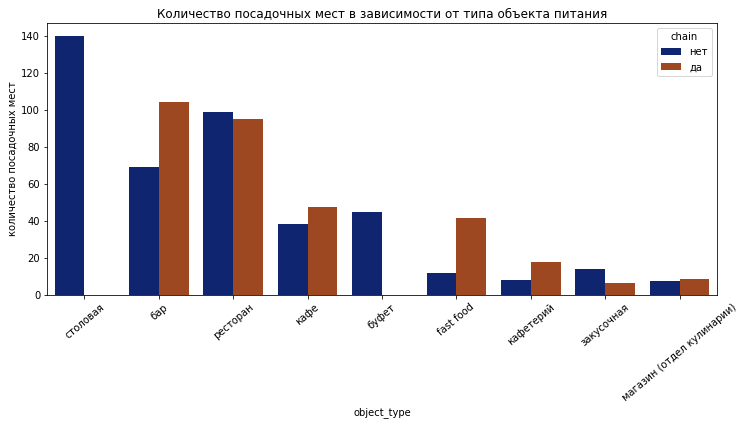

In [15]:
list = df_moscow_10_top_st['st_name'].tolist()

df_moscow_10_st_place = df_moscow.query('adress in @list')
df_moscow_10_st_place.head(10)

data_st_place = df_moscow_10_st_place.groupby(['object_type', 'chain'], as_index=False).agg({'id': 'count' ,'number': 'mean'}).round(2)
data_st_place = data_st_place.sort_values(by='number', ascending=False)
data_st_place

plt.figure(figsize=(12, 5))
ax=sns.barplot(x='object_type', y='number', hue = 'chain', data=data_st_place)
plt.xticks(rotation=40)
plt.title('Количество посадочных мест в зависимости от типа объекта питания')
ax.set_ylabel('количество посадочных мест')
plt.show()

Как мы видим из графика, наибольшее количество посадочных мест на-10 улицах имеют столовые (140), бары и рестораны (около 100). Сетевые бары имеют больше посадочных мест , чем не сетевые; у рестроранов ситуация обратная. Также мы можем отметить, что у сетевых фаст фуд заведений количество посадочных мест куда больше, чем у не сетевых: 40 против 10.       

In [16]:
df_moscow
one_types = df_moscow.groupby('adress', as_index=False).agg({'object_type': 'nunique'}).sort_values(by = 'object_type', ascending = False)
one_types.head()
one = one_types.query('object_type == 1')
len(one)
one = one.rename(columns={'adress':'st_name'})

one = one.merge(
    district,
    on='st_name',
    how='left')

one.head()

,st_name,object_type,areaid,okrug,area
0,улица Степана Шутова,1,115.0,ЮВАО,Район Люблино
1,улица Степана Шутова,1,111.0,ЮВАО,Район Выхино-Жулебино
2,1-й Казачий переулок,1,21.0,ЦАО,Район Якиманка
3,улица Короленко,1,26.0,ВАО,Район Сокольники
4,13-я Парковая улица,1,35.0,ВАО,Район Северное Измайлово


In [17]:
one_ = one['area'].drop_duplicates()
len(one_)

area_nunique = one.groupby('area').agg(
    {'st_name': 'nunique'}).reset_index().sort_values(by='st_name', ascending=False).head(5)
area_nunique.columns = ['район', 'количество улиц']    
area_nunique

,район,количество улиц
100,Таганский район,32
20,Пресненский район,31
85,Район Хамовники,29
3,Басманный район,29
101,Тверской район,28


Всего найдено 804 улицы и 107 райнов, где встречается один тип заведений. Если взять топ-5 районов (все они расположены в центральном административном округе), то здесь находится Тверской район - район офисов, Таганский и Пресненский райн - индустриальные районы, район Хамовники - один из наиболее «образованных» районов города. 

#### Вывод
 
8 улиц из топ-10 представляют собой крупные магистральные улицы, начинающиеся в районе третьего транспортного кольца и идущие на несколько километров. 2 улицы, выбивающиеся из данного списака - это Пресненская набережная (москва-сити) и Кировоградская улица (на ней расположено несколько крупных учебных заведений и торговых центров с фуд-кортами). Наибольшее количество посадочных мест на-10 улицах имеют столовые (140), бары и рестораны (около 100), что объясняется спецификой данных заведений, расчитанных или на большой поток людей (в случае столовых) или на длительное прибывание посетитлей (бары, рестораны). Всего найдено 804 улицы и 107 районов, где встречается только один тип заведения. Даннные улица расположены по всему городу, топ-5 районов по количеству улиц с одним типом питания расположны в центральном административном округе.

### 2. Анализ объектов питания по городу
 
В этом пункте мы:<br>
1.Исследуем соотношение видов объектов общественного питания по количеству.<br>
2. Исследуем соотношение сетевых и несетевых заведений по количеству.<br>
3. Для каждого вида объекта общественного питания опишем среднее количество посадочных мест.<br>


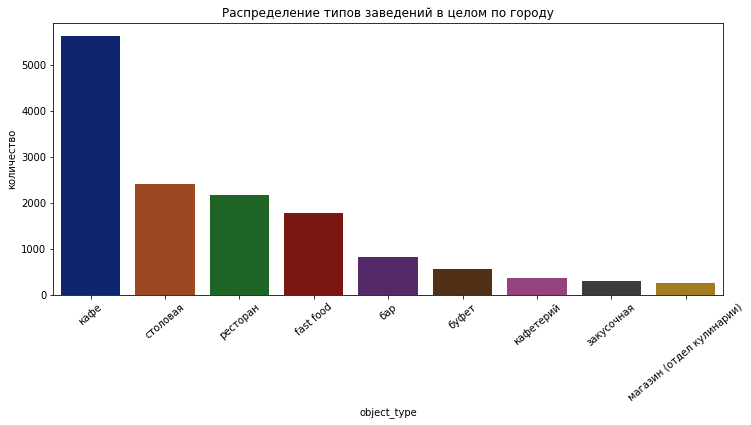

In [18]:
#Постороим график по типам объектов питания
typ_catering = df_moscow.groupby('object_type', as_index=False).agg({'id':'count'}).sort_values('id', ascending=False)
typ_catering.columns = ['object_type','count']

plt.figure(figsize=(12, 5))
ax=sns.barplot(x='object_type', y='count', data=typ_catering)
plt.xticks(rotation=40)
plt.title('Распределение типов заведений в целом по городу')
ax.set_ylabel('количество')
plt.show()

 
Как мы видим, самым распространеным типом заведений являются кафе - больше 5000 заведений. Следом идет, нет, не ресторан и не объекты быстрого питания, а столовые. Рестораны и фаст фуд занимают третье и четвертое места соответсвенно. 

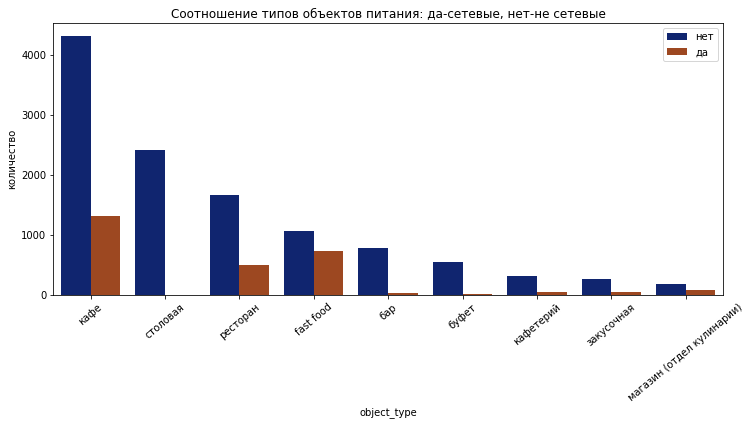

In [19]:
# постороим график распределения по количеству и соотношению сетевых и несетевых заведений
rest_catering = df_moscow.groupby(['object_type', 'chain'], as_index=False).agg({'id':'count'}).sort_values('id', ascending=False)
rest_catering.columns = ['object_type', 'chain', 'count']


plt.figure(figsize=(12, 5))
ax=sns.barplot(x='object_type', y='count', hue='chain', data=rest_catering)
plt.xticks(rotation=40)
plt.title('Соотношение типов объектов питания: да-сетевые, нет-не сетевые')
ax.set_ylabel('количество')
plt.legend()
plt.show()


Большинсвтво заведений являются не сетевыми. Наибольшее количество сетевых заведений среди кафе, фаст фуда и ресторанов. Среди столовых нет сетевых заведений, так как столовые находятся при учебных заведений и заводах. Аналогичная ситуация с буфетами, которые находятся при столовых в учебных заведениях. Основная масса заведений имеет от 15 до 80 посадочных мест.

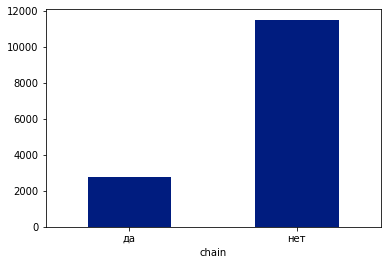

In [20]:
df_moscow.groupby('chain')['object_name'].count().sort_values().plot(kind='bar')
ax.set_title('Соотношенеие сетевых и несетевых объектов общественного питания')
ax.set_xlabel('Тип объекта')
ax.set_ylabel('Количество объектов')
plt.xticks(rotation=0)
plt.show()

Всего в Москве около 2800 сетевых и около 11500 не сетевых объектов. Не сетевых объектов больше примерно в 4 раза, чем сетевых.

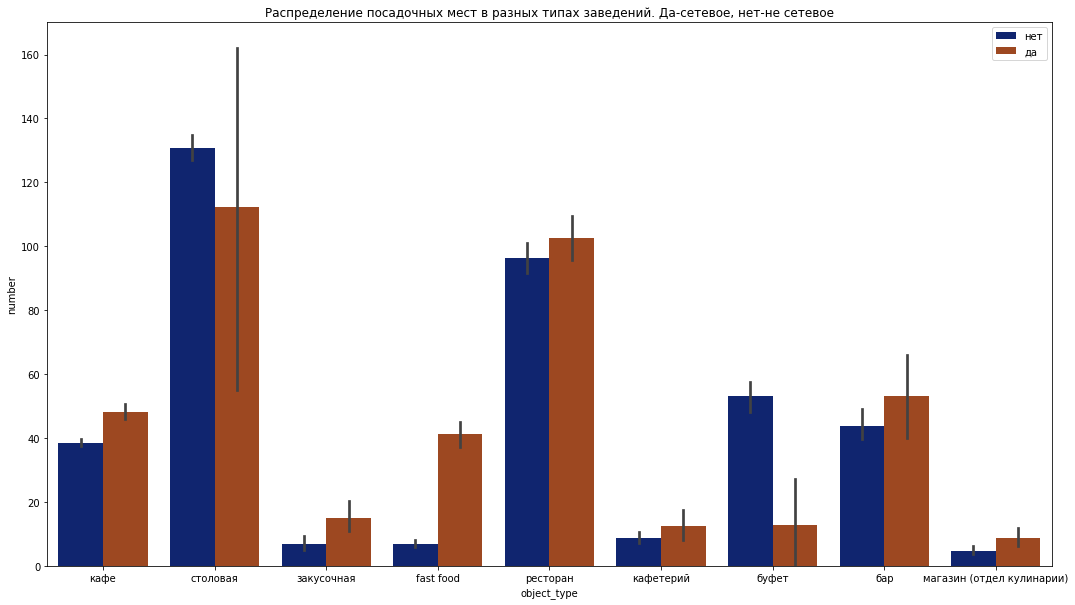

No handles with labels found to put in legend.


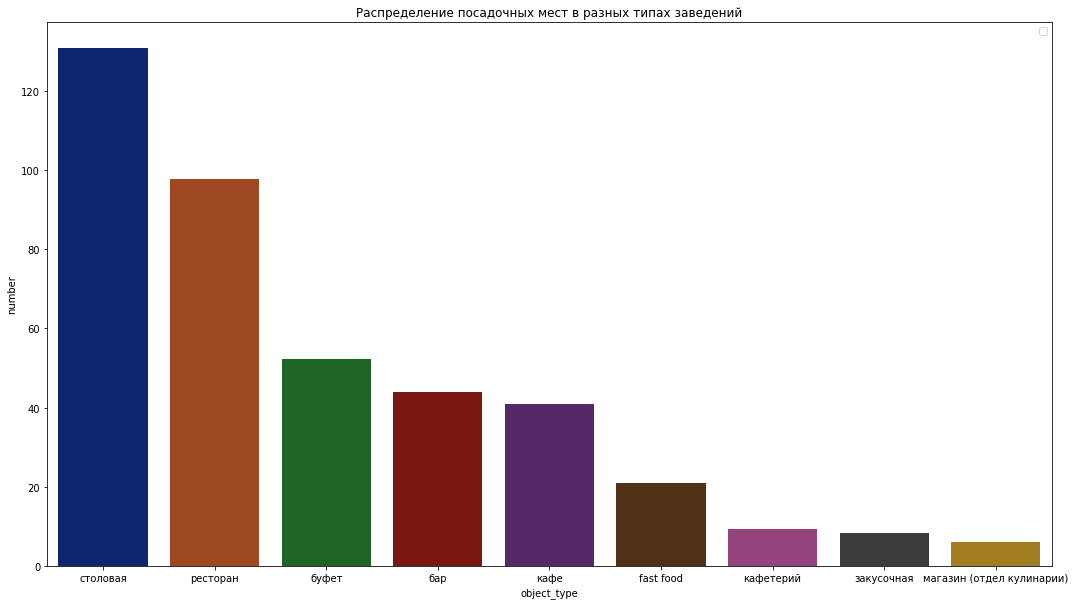

In [21]:
# постоим график количества посадочных мест в зависимости от типа заведения

fig = plt.figure(figsize=(18, 10))
ax = sns.barplot(x='object_type', y='number', hue='chain',data=df_moscow)
ax.legend().get_frame().set_facecolor("white")
plt.title('Распределение посадочных мест в разных типах заведений. Да-сетевое, нет-не сетевое')
plt.show()

df_moscow_seat = df_moscow.groupby('object_type', as_index=False)[
    'number'].mean(). round(2).sort_values(by='number', ascending=False)

fig = plt.figure(figsize=(18, 10))
ax = sns.barplot(x='object_type', y='number', data=df_moscow_seat)
ax.legend().get_frame().set_facecolor("white")
plt.title('Распределение посадочных мест в разных типах заведений')
plt.show()


  
Как и в случае с топ-10 улиц, по городу наибольшее количество посадочных мест у столовых, ресторанов. По городу у сетевых кафе, не сетевых буфетов и сетевых баров среднее количество посадочных мест примерно одинаковое. Самое маленькое коичесвто мест у не сетевых заведений фаст фуда, не сетевых закусочных и не сетевых отделов кулинарии.

In [22]:
df_moscow['number'].describe()

count    14301.000000
mean        60.662122
std         75.630545
min          0.000000
25%         15.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

В большинсвтве заведений города от 15 до 80 мест, в среднем - 40.

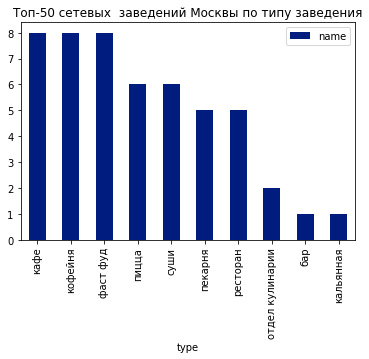

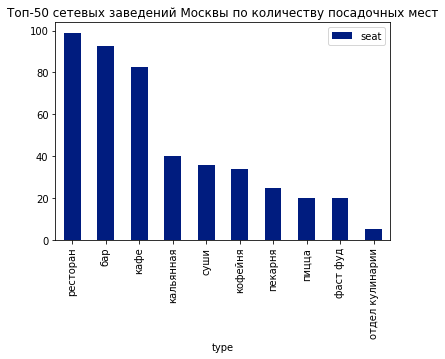

In [23]:
#постоим топ-30 заведений по количеству ресторанов
chain_rest = df_moscow[df_moscow['chain'] == 'да']
top_30_chain = chain_rest.groupby(
    ['object_name_', 'object_type'], as_index=False).agg(
    {'id': 'count', 'number': 'median'}).sort_values(by='id', ascending=False).head(30)
top_30_chain

# упс! некоторые типы заведений введены под разными типами заведений, придется убрать 
#группировку по object_type

top_50_chain = chain_rest.groupby(
    'object_name_', as_index=False).agg(
    {'id': 'count', 'number': 'median'}).sort_values(by='id', ascending=False).head(50)
top_50_chain.columns=['name', 'count', 'seat']
top_50_chain['type'] = ['кофейня', 'фаст фуд', 'фаст фуд', 'фаст фуд', 'суши', 
                        'фаст фуд', 'пицца', 'фаст фуд', 'отдел кулинарии', 'кофейня', 
                        'пицца','кофейня','кафе', 'фаст фуд', 'кафе',
                        'кафе', 'пицца', 'кофейня', 'суши','ресторан',
                        'пекарня', 'ресторан','пекарня','кафе','кальянная',
                        'кафе','кофейня','пицца','пекарня','бар',
                        'пекарня','суши','фаст фуд','кофейня', 'ресторан',
                        'пицца', 'пицца', 'суши','ресторан', 'суши',
                        'кофейня','ресторан', 'фаст фуд','суши','кафе',
                        'кафе','кафе', 'отдел кулинарии', 'кофейня', 'пекарня' ]
top_50_chain
top_50_chain.groupby('type').agg(
    {'name': 'count'}).sort_values(by='name', ascending=False).plot(kind='bar')
plt.title('Топ-50 сетевых  заведений Москвы по типу заведения')
plt.show()

top_50_chain.groupby('type').agg(
    {'seat': 'median'}).sort_values(by='seat', ascending=False).plot(kind='bar')
plt.title('Топ-50 сетевых заведений Москвы по количеству посадочных мест')
plt.show()

 
Если анализировать тип сетевых топ-50 по количеству заведений, то среди них лидируют кафе, фаст фуд и кофейни - по 8 заведений в выборке 50 самых больших сетей. За ними идут суши и пицца (по 6 заведений) и сетевые рестораны (5 заведений). Такое большое количество кофейн и фаст фуда можно объяснить их малой площадью и малым количесвтвом посадочных мест, что позволяет открыть точку в небольших помещениях и увеличить поток клиентов, которые не будут долго задерживаться. Другую ситуацию мы наблюдаем у сетевых ресторанов, баров и кафе, ориентированных на более высокий чек и более длительное прибывание посетителей, которые приходят чаще всего группами: семья, друзья, коллеги. 

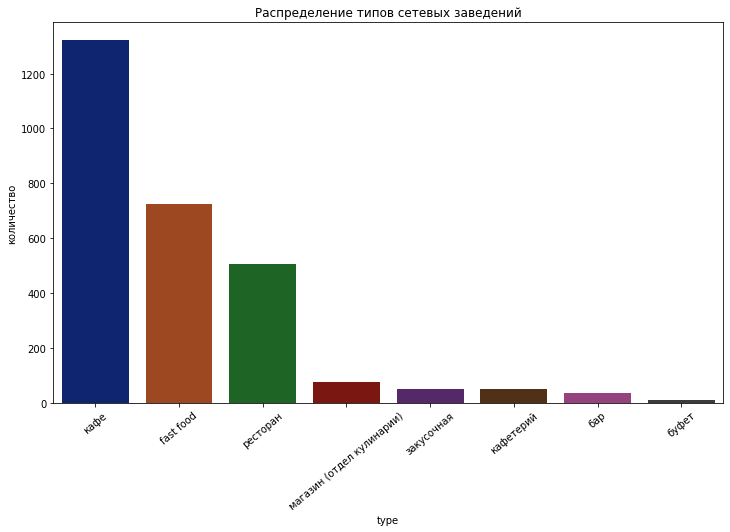

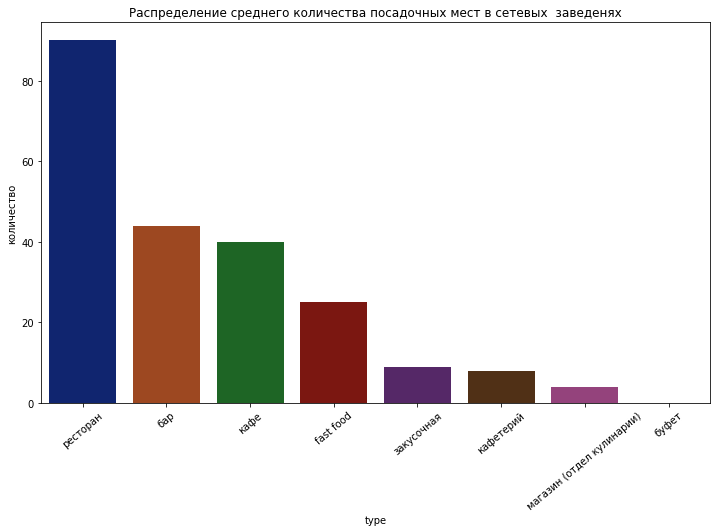

In [24]:
df.head()
chain_rest.head()
data_chain = chain_rest.groupby('object_type', as_index=False).agg(
    {'id': 'count', 'number': 'median'}).sort_values(by='id', ascending=False)
data_chain.columns = ['type', 'count', 'mean_number']
data_chain = data_chain[data_chain['type'] != 'столовая']
# Столовых сетевых нет, это ошибка ввода даных трех заведений (см ячейку ниже), их я уберу

fig = plt.figure(figsize=(12, 7))
ax = sns.barplot(x='type', y='count', data=data_chain)
plt.title('Распределение типов сетевых заведений')
plt.xticks(rotation=40)
ax.set_ylabel('количество')
plt.show()

data_chain = data_chain.sort_values(by='mean_number', ascending=False)
fig = plt.figure(figsize=(12, 7))
ax = sns.barplot(x='type', y='mean_number', data=data_chain)
plt.title('Распределение среднего количества посадочных мест в сетевых  заведенях')
plt.xticks(rotation=40)
ax.set_ylabel('количество')
plt.show()


Если рассматривать распределение типов сетевых заведений, то мы видим,большое количество кафе, фаст фуд и ресторанов. У сетевых ресторанов самое большое количество посадочных мест. За ними идут бары и кафе. 

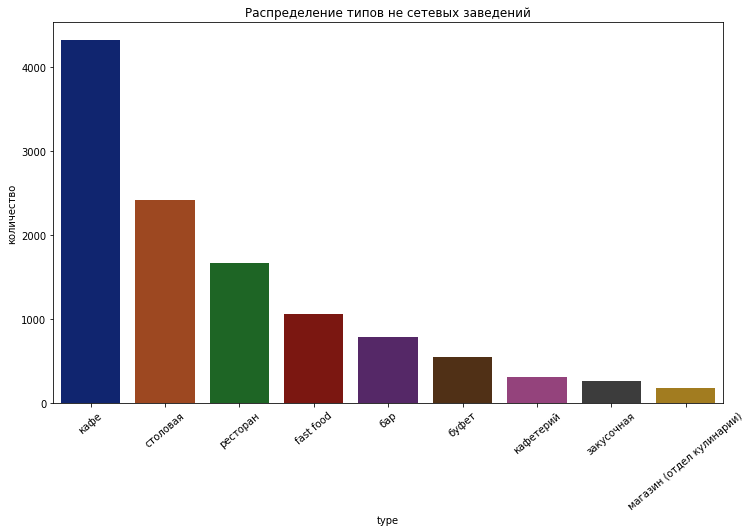

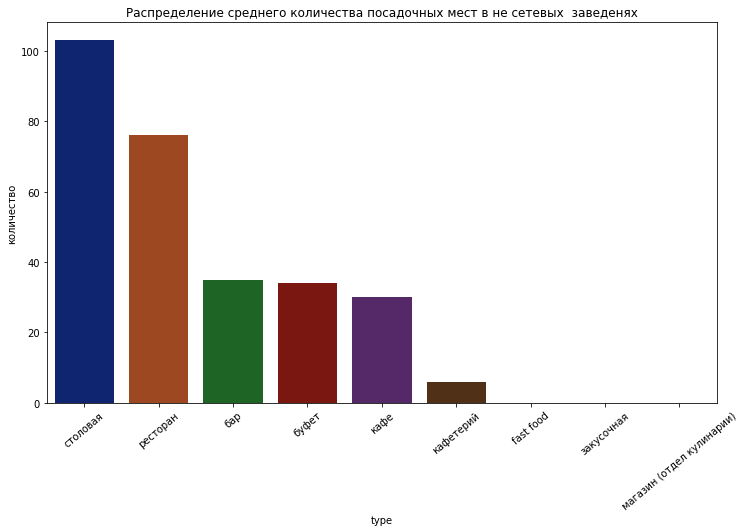

In [25]:
nochain_rest = df_moscow[df_moscow['chain'] == 'нет']
data_nochain = nochain_rest.groupby('object_type', as_index=False).agg(
    {'id': 'count', 'number': 'median'})
data_nochain = data_nochain.sort_values(by='id', ascending=False)
data_nochain.columns = ['type', 'count', 'mean_number']
data_nochain


fig = plt.figure(figsize=(12, 7))
ax = sns.barplot(x='type', y='count', data=data_nochain)
plt.title('Распределение типов не сетевых заведений')
plt.xticks(rotation=40)
ax.set_ylabel('количество')
plt.show()

data_nochain = data_nochain.sort_values(by='mean_number', ascending=False)
fig = plt.figure(figsize=(12, 7))
ax = sns.barplot(x='type', y='mean_number', data=data_nochain)
plt.title('Распределение среднего количества посадочных мест в не сетевых  заведенях')
plt.xticks(rotation=40)
ax.set_ylabel('количество')
plt.show()

Если сравнивать между собой распределение типов заведений и количества посадочных мест, то кафе - лидеры в обеих группах. Распределение типов заведений в не сетевых объектах - аналогично по городу (влияние соотношения сетевых: не сетевых заведений - 1:4). Что касается посадочных мест - то в несетевых заведениях лидируют столовые и рестораны, за ними следуют бары и буфеты, и только на третьем месте кафе. Такие заведения как фаст фуд, хзакусочная и отдел кулинарии, в среднем, не имеют посадочных мест (для сранения в сетевых заведениях ситуация следующая: ресторан, бар, кафе, фаст фуд).

In [26]:
chain_rest[chain_rest['object_type'] == 'столовая']


,id,object_name,chain,object_type,address,number,object_name_,adress,city
5234,20979,ГРАБЛИ,да,столовая,"город Москва, Ярославское шоссе, дом 26, корпус 1",120,Грабли,Ярославское шоссе,Moscow
5967,104941,Му-Му,да,столовая,"город Москва, Люблинская улица, дом 169, корпус 2",55,Му-му,Люблинская улица,Moscow
6574,78347,Гурман,да,столовая,"город Москва, Оршанская улица, дом 3",162,Гурман,Оршанская улица,Moscow


#### Вывод
 
1. В структуре ООП по городу преобладают кафе, столовые и рестораны. Кафе – самый популярный тип заведени. <br>
2. Соотношение сетевых: не сетевых заведений – 1:4.<br>
3. Среди сетевых ООП преобладают кафе, фаст фуд и рестораны, среди сетевых – кафе, столовые и рестораны.<br>
4. Наибольшее количество посадочных мест у столовых и ресторанов. <br>
5. Основная масса заведений имеет от 15 до 80 посадочных мест.<br>
6.  В топ-50 по количеству сетевых заведений лидируют кафе, кофейни и фаст фуд.<br>
7. 8 из 10 улиц по количеству ООП – это крупные магистральные улицы, начинающиеся в районе 3-го транспортного кольца. <br>
8. На топ-10 улиц по количеству ОПП количесвто посадочных мест в сетевых заведениях больше. <br>
9. Всего найдено 804 улицы и 107 районов, где встречается один тип заведений. <br>


#### Тренды рынка общественного питания
  
Москва и Москвоская область являются лидерами рынка общественного питания и наиболее перспективной отраслью российской экономики. Данная сфера характеризуется высокой конкуренцией. Основными тенденциями на этом рынке являются:<br>
    1. Развитие новых форматов. Сетевые кофейни и сети фаст фуд начали осваивать "чужие" территории. Так, сеть Cofix открывает свои точки внутри магазинов «М.Видео». В «М.Видео» действует сокращенное меню Cofix: гости могут купить сэндвичи, салаты и блюда завтраков. Средний чек составит 111 рублей, тогда как во всей остальной сети он равняется 134 рублям. За каждую покупку клиенты получат бесплатный кофе. Подобное соглашение заключили McDonald's и Сбербанк. В Москве у метро «Новослободская» открылось первое отделение Сбербанка, совмещенное с McDonald's.<br>
    2. Развитие доствки, в том числе бесконтактной: пандемия ковид заставила многие заведения заняться доставкой еды, особенно те блюда, которые невозможно приготовить самому. Существует два основных способа организации доставки: через собстаенный сайт или приложение, или через крупные сервисы доставки: Delivery Club, «Яндекс. Еда», «Самокат» и др.<br>
    3. Как видно из топ-50 сетевых заведений, самыми большими игроками на данном рынке являются сеть кофейг "Шоколадница",  KFC	,Макдоналдс	и  Бургер кинг. Сегмент фаст фуда всегда популярен, но пандемия короновируса сделала его еще болеее востребованным: невысокие цены и быстрое обслуживание дают преимущество таким сетям. <br>
    4.В структуре заведений много ресторанов, баров, кафе, кофеин. Рынок перенасыщен данным числом заведений. Поэтому на первый план выходит конкуренция в продуманности концепции заведения: начиная от меню и интерьера, заканчивая обслуживанием. <br>
    5. Усиление присутствия в социальных сетях, которые используют как средство поддержания имиджа, коммуникации с целевой аудиторией, получение обратной связи, отслеживание отзывов и нейтрализацию негатива.<br><br>
    Источники: https://www.the-village.ru/business/news/369885-mvideo-cofix?from=frontpage?from=frontpage<br>    https://www.vedomosti.ru/finance/articles/2019/12/20/819247-v-moskve-pervii-mcdonalds<br>
    https://academyopen.ru/journal/497<br>
    https://gidmark.ru/cat1/marketingovoe-issledovanie-rynka-obcshestvennogo-pitaniya-v-moskve-i-mo<br>
    https://www.openbusiness.ru/biz/business/obzor-rynka-obshchestvennogo-ritaniya/

#### Комментарий студента для инвесторов
 
 Советую учитывать мировую практику, так как подобные заведения есть в мире. Их можно разделить на бары (как в Вене, Чехии и Лос-Анжелесе ) и рестораны (как в Гонконге, Китае). <br>
Кухня: простая: пиво, фаст фуд, лапша (для азиатских стран).<br>
Средний чек: не высокий.<br>
Затраты: большие: аренда помещения + внедрение технологии (самая высокая доля). Один робот стоит от 9 тыс дол (в зависимости от функционала). Значит, себестоимость исходных продуктов питания должна быть не высокая. Обязательно должен быть алкоголь, так как его продажа увеличивает средний чек. (Может, рассмотреть чешский вариант с паровозами, которые доставляют еду?)<br>
Посадочные места: много (отталкивайтесь от среднего по Москве – должно быть больше 40), так как выручка идет за счет объема продаж. Можно сэкономить на аренде и открыться не в центре. Концепция оригинальная, люди готовы будут ехать. <br>
Атмосфера: веселая, люди идут в такие заведения отдохнуть и посидеть компаниями. <br>
Развлекательная программа: приветствуется, роботы должны не только ездить, но и развлекать гостей: танцевать, разговаривать и так далее. <br>
Дополнительно: необходимо завести страницу в социальных сетях, чтобы регулярно публиковать фото и видео, дополнительно привлекая людей.  <br>
Резюмируем:<br>
    основные затраты - внедрение роботов и ПО под них, специалисты для обслуживания<br>
    на чем можно сэкономить - аренда, закупка продуктов и алкоголя (продукты должны быть качественными и недорогими); персонал - нет офицантов (экономим 1000 дол / мес + налог в ФСЗН и пенсионный фонд), приготовление блюд не должно требовать от поворов специфических навыков, рецептура должна быть максимально простой в приготовлении.<br>
    Важно: В США роботизированные рестораны, как правило, открываются в дорогих городах и штатах, так как минимальная оплата труда - 13-15 дол в час. Медианная зарплата официанта в Москве - 79 тыс/мес - 1079 дол / мес. То есть, каждый месяц можно сэкономить 1000 дол на одном официанте + экономия на отчислениях в ФСЗН и пенсионный фонд + экономия на больничных<br>
    В Росии существует сеть робото-кафе - MontyCafe, представляющее собой автомат, который варит кофе. Такие точки установлены уже в Москве, Рязани, Москве, Мурманске. Работают по франшизе. Инвестиции в кафе от 1.500.000 руб.

<br>
<br>
Источники:<br>

https://trends.rbc.ru/trends/industry/5eeb99fa9a79475c9e9c5f2e<br>
https://rb.ru/longread/food-robotics/  <br>
https://montycafe.ru/<br>


Презентация: https://docs.google.com/presentation/d/1AV8KDYvw8khCyBunxqgSQCm_BfU4gb4j/edit?usp=sharing&ouid=111955281232043079411&rtpof=true&sd=true
        